In [2]:
%cd ..

/home/chickencurry/emb-ml-challenge


In [3]:
import torch
from matplotlib import pyplot as plt
from utils.train_eval import validate
from utils.dataloader import VOCDataLoaderPerson
from utils.tinyyolov2 import TinyYoloV2Pruned, TinyYoloV2Fused
# from utils.metrics import get_num_macs, get_num_params, get_size_on_disk, get_time, get_time_onnx
import pandas as pd
import os.path

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
load_paths = ["./runs/voc_pretrained.pt", "./runs/voc_person_only.pt"]
load_paths = load_paths + [f'./runs/taylor2/voc_pruned_{n}_finetuned.pt' for n in range(10)]

In [6]:
aps = []
sizes_on_disk = []
nums_macs = []
nums_params = []
times = []
times_fused = []
times_onnx = []

In [7]:
# val_loader = VOCDataLoaderPerson(train=False, batch_size=1)

# for load_path in load_paths:
#     num_classes = 20 if load_path == "./runs/voc_pretrained.pt" else 1

#     model = TinyYoloV2Pruned(num_classes=num_classes)
#     state_dict = torch.load(load_path)
#     model.load_state_dict(state_dict, strict=False)
#     model = model.to(device)

#     aps.append(validate(model, device, val_loader, roc=False))
#     sizes_on_disk.append(get_size_on_disk(state_dict))
#     nums_macs.append(get_num_macs(model))
#     nums_params.append(get_num_params(model))

#     print(f"average precision: {aps[-1]}") 
#     print(f"size on disk: {sizes_on_disk[-1]} MB")
#     print(f"num macs: {nums_macs[-1]}") 
#     print(f"num params: {nums_params[-1]}") 

In [8]:
for load_path in load_paths:
    num_classes = 20 if load_path == "./runs/voc_pretrained.pt" else 1
    
    model = TinyYoloV2Pruned(num_classes=num_classes)
    state_dict = torch.load(load_path)
    model.load_state_dict(state_dict, strict=False)
    model = model.to(device)
    
    times.append(get_time(model, device))
    print(f"time: {times[-1]} ms")

NameError: name 'get_time' is not defined

In [ ]:
for load_path in load_paths:
    num_classes = 20 if load_path == "./runs/voc_pretrained.pt" else 1
    
    model_fused = TinyYoloV2Fused(num_classes=num_classes)
    state_dict_fused = torch.load(load_path)
    model_fused.load_state_dict(state_dict_fused, strict=False)
    model_fused.fuse_after_loading_sd()
    model_fused = model_fused.to(device)
    
    times_fused.append(get_time(model_fused, device))
    print(f"time fused: {times_fused[-1]} ms")

time fused: 50.90989351272583 ms
time fused: 55.28303861618042 ms
time fused: 415.1497149467468 ms
time fused: 30.907976627349854 ms
time fused: 21.21967315673828 ms
time fused: 19.198601245880127 ms
time fused: 17.441744804382324 ms
time fused: 16.582212448120117 ms
time fused: 15.767827033996582 ms
time fused: 14.816477298736572 ms
time fused: 14.411370754241943 ms
time fused: 13.360621929168701 ms


In [ ]:
for load_path in load_paths:
    num_classes = 20 if load_path == "./runs/voc_pretrained.pt" else 1
    
    model = TinyYoloV2Pruned(num_classes=num_classes)
    state_dict = torch.load(load_path)
    model.load_state_dict(state_dict, strict=False)
    
    # if not os.path.isfile(f"{load_path}.onnx"):
    #    torch.onnx.export(model, torch.zeros(1, 3, 320, 320), f"{load_path}.onnx", opset_version=11, input_names = ['input'], output_names = ['output'])
        
    times_onnx.append(get_time_onnx(device, load_path, num_classes))
    print(f"time onnx: {times_onnx[-1]} ms")

time onnx: 183.99203062057495 ms
time onnx: 147.36319780349731 ms
time onnx: 35.41670560836792 ms
time onnx: 26.28645896911621 ms
time onnx: 33.29018592834473 ms
time onnx: 30.26130199432373 ms
time onnx: 25.38738489151001 ms
time onnx: 22.38049030303955 ms
time onnx: 19.732980728149414 ms
time onnx: 17.493278980255127 ms
time onnx: 21.204264163970947 ms
time onnx: 19.674227237701416 ms


In [ ]:
dict = {
    # "Average Precision": aps,
    # "Size on Disk in MB": sizes_on_disk,
    # "Num MACs": nums_macs,
    # "Num Params": nums_params,
    "Time in ms": times,
    "Time Fused in ms": times_fused,
    "Time ONNX in ms": times_onnx
}

df = pd.DataFrame.from_dict(dict)
df.index = [p.split("/")[-1] for p in load_paths]
df.head(20)

df.to_csv("./runs/time_results.csv")

In [10]:
df = pd.read_csv("./runs/results.csv", index_col=0)
df_time = pd.read_csv("./runs/time_results.csv", index_col=0)

df_new = pd.DataFrame.from_dict({"Time in ms": [52.69, 51.85, 28.43, 21.88, 18.91, 16.84, 15.4, 14.29, 14.02, 12.82, 12.35, 12.2]})
df_new.index = [p.split("/")[-1] for p in load_paths]

df["Time in ms"] = df_new["Time in ms"]

display(df_new.head())
display(df.head())
display(df_time.head())

fused_ratios = df_time["Time Fused in ms"] / df_time["Time in ms"]
print(f"fused ratios: {fused_ratios}")

,Time in ms
voc_pretrained.pt,52.69
voc_person_only.pt,51.85
voc_pruned_0_finetuned.pt,28.43
voc_pruned_1_finetuned.pt,21.88
voc_pruned_2_finetuned.pt,18.91


,Average Precision,Size on Disk in MB,Num MACs,Num Params,Time in ms,Time Fused in ms
voc_pretrained.pt,0.647943,70.800601,2062457012,15861773,52.69,25.733209
voc_person_only.pt,0.654683,70.800601,2052719512,15764398,51.85,25.252478
voc_pruned_0_finetuned.pt,0.632039,40.773437,1381510996,9078559,28.43,15.814543
voc_pruned_1_finetuned.pt,0.636418,27.547717,1085861082,6131622,21.88,13.311388
voc_pruned_2_finetuned.pt,0.592733,19.839901,912243632,4415639,18.91,12.069809


,Time in ms,Time Fused in ms
voc_pretrained.pt,0.964553,0.843253
voc_person_only.pt,0.977495,0.779164
voc_pruned_0_finetuned.pt,0.971546,0.832257
voc_pruned_1_finetuned.pt,0.963528,0.791085
voc_pruned_2_finetuned.pt,0.966852,0.778611


fused ratios: voc_pretrained.pt            0.874242
voc_person_only.pt           0.797103
voc_pruned_0_finetuned.pt    0.856632
voc_pruned_1_finetuned.pt    0.821029
voc_pruned_2_finetuned.pt    0.805305
voc_pruned_3_finetuned.pt    0.803517
voc_pruned_4_finetuned.pt    0.739787
voc_pruned_5_finetuned.pt    0.810750
voc_pruned_6_finetuned.pt    0.800164
voc_pruned_7_finetuned.pt    0.802352
voc_pruned_8_finetuned.pt    0.793499
voc_pruned_9_finetuned.pt    0.811014
dtype: float64


/tmp/ipykernel_27031/2551868573.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(labels, rotation=45)


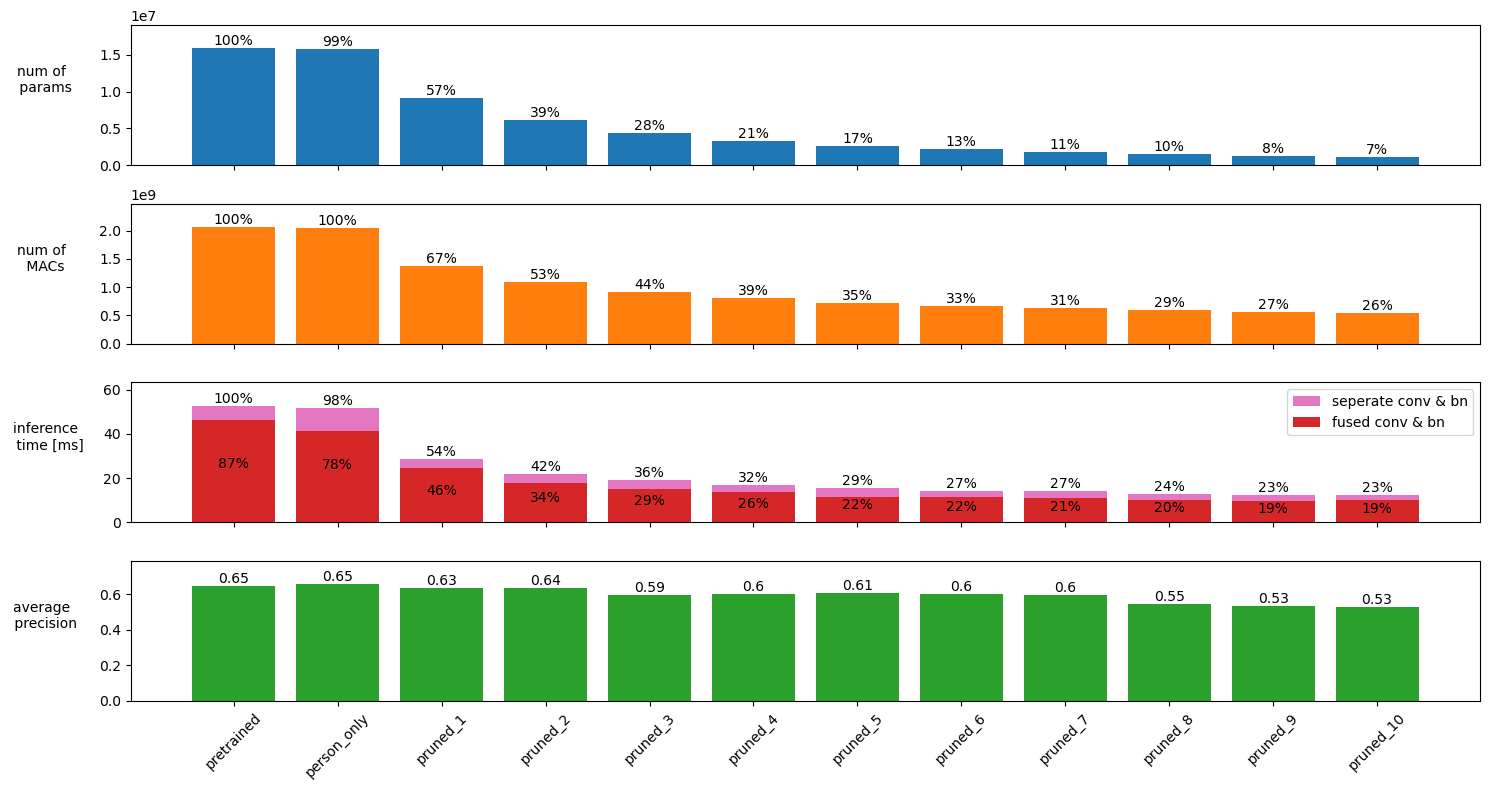

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(15, 8), sharex=True)

labels = ["pretrained", "person_only", "pruned_1", "pruned_2", "pruned_3", "pruned_4", "pruned_5", "pruned_6", "pruned_7", "pruned_8", "pruned_9", "pruned_10"]

def get_percentages(df, base):
    vals = df / base
    return [f"{v:.0%}" for v in vals]

ax[0].bar(df.index, df["Num Params"], color="tab:blue")
ax[0].set_ylabel("num of \n params", rotation=0, labelpad=40)
# ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_ylim(0, 1.2 * df["Num Params"].max())
ax[0].bar_label(ax[0].containers[0], labels=get_percentages(df["Num Params"], df["Num Params"].max()), label_type="edge")

ax[1].bar(df.index, df["Num MACs"], color="tab:orange")
ax[1].set_ylabel("num of \n MACs", rotation=0, labelpad=40)
# ax[1].set_xticklabels(labels)
ax[1].set_ylim(0, 1.2 * df["Num MACs"].max())
ax[1].bar_label(ax[1].containers[0], labels=get_percentages(df["Num MACs"], df["Num MACs"].max()), label_type="edge")

ax[2].bar(df.index, df["Time in ms"], color="tab:pink", label = "seperate conv & bn")
ax[2].bar(df.index, df["Time in ms"] * fused_ratios, color="tab:red", label = "fused conv & bn")
ax[2].set_ylabel("inference \n time [ms]", rotation=0, labelpad=40)
# ax[2].set_xticklabels(labels)
ax[2].set_ylim(0, 1.2 * df["Time in ms"].max())
ax[2].bar_label(ax[2].containers[0], labels=get_percentages(df["Time in ms"], df["Time in ms"].max()), label_type="edge")
ax[2].bar_label(ax[2].containers[0], labels=get_percentages(df["Time in ms"] * fused_ratios, df["Time in ms"].max()), label_type="center")
ax[2].legend(loc="upper right")

ax[3].bar(df.index, df["Average Precision"], color="tab:green")
ax[3].set_ylabel("average \n precision", rotation=0, labelpad=40)
ax[3].set_xticklabels(labels, rotation=45)
ax[3].set_ylim(0, 1.2 * df["Average Precision"].max())
ax[3].bar_label(ax[3].containers[0], labels=df["Average Precision"].round(2), label_type="edge")

fig.tight_layout()
plt.show()

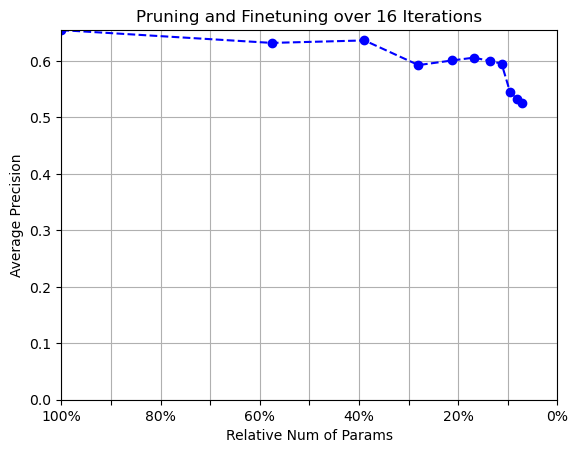

In [9]:
plt.figure(figsize=(10, 5))
plt.ylim(0, max(aps))
percentages = [s/nums_params[0] for s in nums_params]

plt.plot(percentages, aps, '--bo')
plt.title("Pruning and Finetuning over 16 Iterations")
plt.xlabel("Relative Num of Params")
plt.ylabel("Average Precision")
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ["0%", "", "20%", "", "40%", "", "60%", "", "80%", "", "100%"])
plt.xlim(0, 1.0)
plt.gca().invert_xaxis()
plt.grid()
plt.savefig("./figures/pruning_run_ap_params.png")
plt.show()

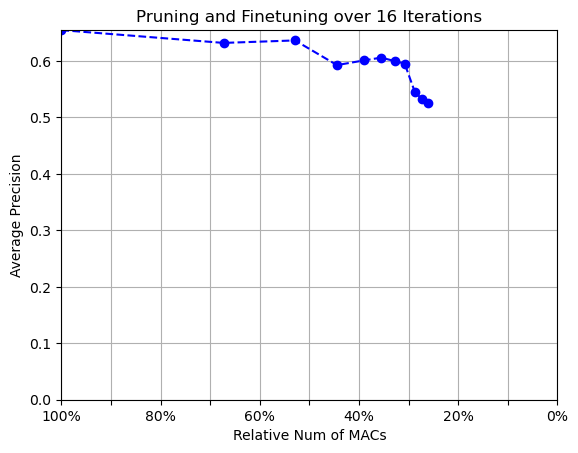

In [10]:
plt.figure()
plt.ylim(0, max(aps))
percentages = [s/nums_macs[0] for s in nums_macs]

plt.plot(percentages, aps, '--bo')
plt.title("Pruning and Finetuning over 16 Iterations")
plt.xlabel("Relative Num of MACs")
plt.ylabel("Average Precision")
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ["0%", "", "20%", "", "40%", "", "60%", "", "80%", "", "100%"])
plt.xlim(0, 1.0)
plt.gca().invert_xaxis()
plt.grid()
plt.savefig("./figures/pruning_run_ap_macs.png")
plt.show()

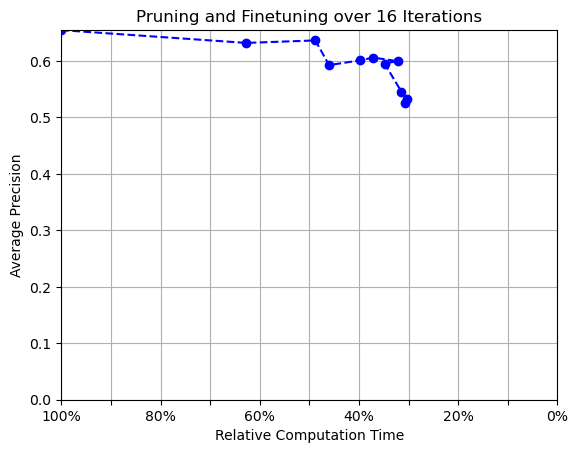

In [11]:
plt.figure()
plt.ylim(0, max(aps))

percentages = [s/times[0] for s in times]

plt.plot(percentages, aps, '--bo')
plt.title("Pruning and Finetuning over 16 Iterations")
plt.xlabel("Relative Computation Time")
plt.ylabel("Average Precision")
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ["0%", "", "20%", "", "40%", "", "60%", "", "80%", "", "100%"])
plt.xlim(0, 1.0)
plt.gca().invert_xaxis()
plt.grid()
plt.savefig("./figures/pruning_run_ap_times.png")
plt.show()